In [1]:
import sys
sys.path.insert(1, '/home/BCCRC.CA/ssubedi/projects/experiments/asapp/asap/python')
sys.path.insert(1, '/home/BCCRC.CA/ssubedi/projects/experiments/asapp/asap')

from util._io import read_config
from collections import namedtuple
from pathlib import Path
import pandas as pd
import numpy as np
import logging
from scannotation import ASAPP
import asapc 
from data._dataloader import DataSet
from util import _topics


import matplotlib.pylab as plt
import seaborn as sns
import colorcet as cc

from data import _sim 
from scipy import stats
from sklearn.metrics import mean_squared_error as mse

import joblib

experiment = '/projects/experiments/asapp/'
server = Path.home().as_posix()
experiment_home = server+experiment
experiment_config = read_config(experiment_home+'config.yaml')
args = namedtuple('Struct',experiment_config.keys())(*experiment_config.values())

dl = DataSet(data_ondisk=False)
dl.config = args
dl.initialize_path()
dl.initialize_data()
print(dl.inpath)
print(dl.outpath)


/home/BCCRC.CA/ssubedi/projects/experiments/asapp/data/pbmc/pbmc
/home/BCCRC.CA/ssubedi/projects/experiments/asapp/result/pbmc/pbmc


In [2]:
dl.load_data()
asap = ASAPP(adata=dl,tree_min_leaf=1, tree_max_depth=10,factorization='VB', max_iter=100)
asap.get_pbulk()

In [4]:
asap.pbulk_mat.shape

(573, 13745)

In [5]:

K = 10
model = asapc.ASAP(asap.pbulk_mat.T,K)
dcpmf = model.run()

Starting nmf...
-12412021.0
-12412021.0
-12412021.0
-3787254.75
-3787254.75
-3787254.75
-4010088.5
-4010088.5
-4010088.5
-4282502.0
-4282502.0
-4282502.0
-4109795.0
-4109795.0
-4109795.0
-3861221.25
-3861221.25
-3861221.25
-3738323.25
-3738323.25


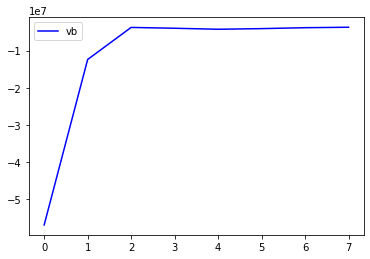

In [6]:
plt.plot(dcpmf.C,'b',label='vb')
plt.legend()

In [10]:
dcpmf.B.shape

(573, 10)

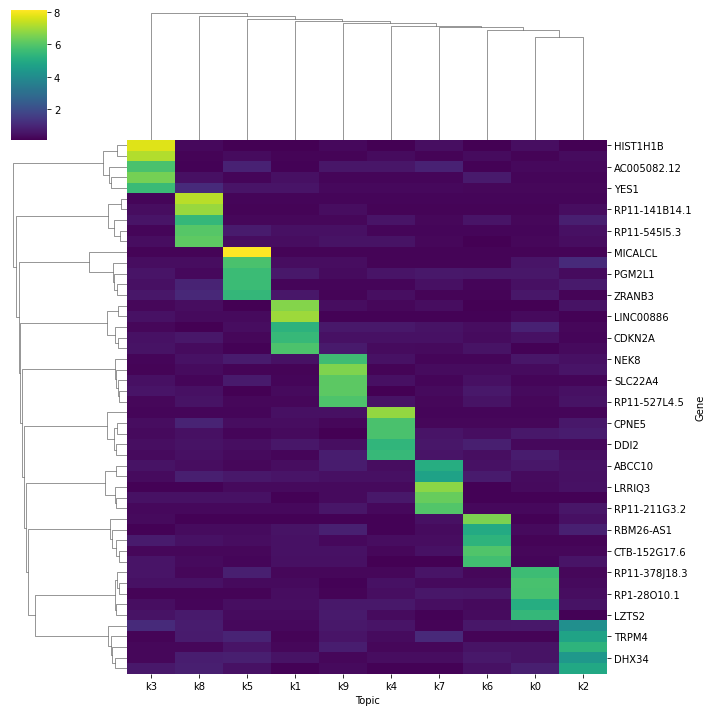

In [12]:
df_beta = pd.DataFrame(dcpmf.A.T)
df_beta.columns = dl.cols
df_top = _topics.get_topic_top_genes(df_beta.iloc[:,:],top_n=5)
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')
sns.clustermap(df_top.T,cmap='viridis')

In [13]:
import umap

df_pl = pd.read_csv(dl.outpath+'_prior_label.csv.gz')

df_theta = pd.DataFrame(dcpmf.B)
df_umap= pd.DataFrame()
df_umap['cell'] = dl.rows
df_umap['topic'] = [x for x in df_theta.iloc[:,1:].idxmax(axis=1)]

umap_2d = umap.UMAP(n_components=2, init='random', random_state=0,min_dist=0.0,metric='cosine')
proj_2d = umap_2d.fit(df_theta.iloc[:,1:])
df_umap[['umap1','umap2']] = umap_2d.embedding_[:,[0,1]]
df_umap
df_umap = pd.merge(df_umap,df_pl[['cell','cell_type']],on='cell',how='left')
df_umap = df_umap[~df_umap['cell_type'].isna()]
df_umap

figure,axis = plt.subplots(2,1)
plt.rcParams["figure.figsize"] = (10,10)


cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['cell_type'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='cell_type',s=2,palette=cp,legend=True,ax=axis[0])
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
p.axes.set_title("SPRUCE",fontsize=30)


cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['topic'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='topic',s=2,palette=cp,legend=True,ax=axis[1])
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
p.axes.set_title("dcpmf",fontsize=30)

ValueError: Length of values (573) does not match length of index (2700)

In [7]:
df_grp = df_umap.groupby(['topic','cell_type'])['cell_type'].size().rename('count').reset_index()
celltype_sum = dict(df_grp.groupby('topic')['count'].sum())
df_grp['ncount'] = [x/celltype_sum[y] for x,y in zip(df_grp['count'],df_grp['topic'])]
df_grp['topic'] =  df_grp['topic'].astype(int)
df_grp.to_csv(dl.outpath+'_r1_topic_ct_dist.csv.gz',index=False, compression='gzip')